In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import os 
from scipy.stats import wilcoxon, ttest_rel
from tabulate import tabulate
from functions.test_algorithms import test_slim
from slim_gsgp_lib.utils.utils import train_test_split
from slim_gsgp_lib.datasets.data_loader import *
datasets = [globals()[i] for i in globals() if 'load' in i][2:]
datasets = datasets[:12] + datasets[13:]  # EXCLUDE PARKINSONS

dataset_dict = {}
df_datasets = {}
for i, dataset in enumerate(datasets):
    X,y = dataset()
    name = dataset.__name__.split('load_')[1]
    # id should be a two digit number
    id = 'DA' + str(i).zfill(2)
    dataset_dict[name] = id 
    df_datasets[name] = X.shape[0], X.shape[1]

df_datasets

{'resid_build_sale_price': (372, 107),
 'istanbul': (536, 7),
 'airfoil': (1503, 5),
 'bike_sharing': (731, 13),
 'boston': (506, 13),
 'breast_cancer': (569, 30),
 'concrete_slump': (103, 7),
 'concrete_strength': (1005, 8),
 'diabetes': (442, 10),
 'efficiency_heating': (768, 8),
 'efficiency_cooling': (768, 8),
 'forest_fires': (513, 43),
 'ld50': (234, 626),
 'ppb': (131, 626),
 'bioav': (358, 241)}

In [22]:
# Aggregate the dictionary of params and results, as they were saved in separate files
params_dict = {}
results_dict = {}

for dataset in datasets:
    try:
        dataset_name = dataset.__name__.split('load_')[1]
        dataset_id = dataset_dict[dataset_name]

        # The file will have this pattern: algorithm_scxo.pkl. 
        # We need to ensure only that for some settings (ex.: scxo) all the algorithms are present
        avalaible_settings = []
        for file in os.listdir(f'results/slim/{dataset_id}'):
            # Get the different settings available 
            if len(file.split('_')) < 3:
                continue
            settings = file.split('_')[2].split('.')[0]
            if settings not in avalaible_settings:
                avalaible_settings.append(settings)
        
        for settings in avalaible_settings:
            dict_params = {}
            dict_results = {}
            for suffix in ['MUL_ABS', 'MUL_SIG1', 'MUL_SIG2', 'SUM_ABS', 'SUM_SIG1', 'SUM_SIG2']:
                try:
                    # Parameters
                    with open(f'params/{dataset_id}/{suffix}_{settings}.pkl', 'rb') as f:
                        params = pickle.load(f)
                    params = {suffix : params}
                    dict_params.update(params)
                    os.remove(f'params/{dataset_id}/{suffix}_{settings}.pkl')
                except Exception as e:
                    print(f"Error in parameters {dataset_id} - {settings}: {e}")

                try:
                    # Results
                    with open(f'results/slim/{dataset_id}/{suffix}_{settings}.pkl', 'rb') as f:
                        results = pickle.load(f)
                    for k, v in results.items():
                        if k not in dict_results:
                            dict_results[k] = {}
                        v = {suffix : v}
                        dict_results[k].update(v)
                    os.remove(f'results/slim/{dataset_id}/{suffix}_{settings}.pkl')

                except Exception as e:
                    print(f"Error in results {dataset_id} - {settings}: {e}")
                    continue
            
            # Dump the results
            pickle.dump(dict_params, open(f'params/{dataset_id}/{settings}_10.pkl', 'wb'))
            pickle.dump(dict_results, open(f'results/slim/{dataset_id}/{settings}_10.pkl', 'wb')) 

    except Exception as e:
        print(f"Error in processing dataset: {e}")
        continue       

In [23]:
def get_significance(p_value, ratio, detailed=False):
    if p_value >= 0.05:
        return 'NSD'
    elif ratio > 1:
        return '-' * (1 + int(p_value < 0.01) + int(p_value < 0.001)) if detailed else '-'
    else:
        return '+' * (1 + int(p_value < 0.01) + int(p_value < 0.001)) if detailed else '+'

def means_df(prefixes=['sc', 'scsm'],
             datasets=None,
             best=False,
             rmse_compare=True,
             decimals=3,
             table=False, 
             detailed=False):
    
    if datasets is None:
        datasets = dataset_dict.keys()
    
    rows_rmse, rows_rmse_std, rows_size, rows_size_std = [], [], [], []
    rmse_sig_test, size_sig_test = {}, {}

    for dataset in datasets:
        if dataset not in rmse_sig_test:
            rmse_sig_test[dataset] = {}
            size_sig_test[dataset] = {}

        for prefix in prefixes: 
            if prefix not in rmse_sig_test[dataset]:
                rmse_sig_test[dataset][prefix] = {}
                size_sig_test[dataset][prefix] = {}
                
            with open(f'results/slim/{dataset_dict[dataset]}/{prefix}.pkl', 'rb') as f:
                results = pickle.load(f)
                rmse = results['rmse_compare'] if rmse_compare else results['rmse']
                size = results['size']

            for algo, values in rmse.items():

                rows_rmse.append({'Dataset': dataset, 'Algorithm': algo, f'rmse_{prefix}': np.mean(values)})
                rows_size.append({'Dataset': dataset, 'Algorithm': algo, f'size_{prefix}': np.mean(size[algo])})
                rows_rmse_std.append({'Dataset': dataset, 'Algorithm': algo, f'rmse_std_{prefix}': np.std(values)})
                rows_size_std.append({'Dataset': dataset, 'Algorithm': algo, f'size_std_{prefix}': np.std(size[algo])})
                rmse_sig_test[dataset][prefix][algo] = np.array(values)
                size_sig_test[dataset][prefix][algo] = np.array(size[algo])
                
    df_rmse = pd.DataFrame(rows_rmse)
    df_size = pd.DataFrame(rows_size)
    df_rmse_std = pd.DataFrame(rows_rmse_std)
    df_size_std = pd.DataFrame(rows_size_std)

    # Pivot tables and explicitly reorder columns based on the given prefixes
    df_rmse = df_rmse.pivot_table(index=['Dataset', 'Algorithm'], values=[f'rmse_{p}' for p in prefixes], 
                                aggfunc='first').reset_index()
    df_size = df_size.pivot_table(index=['Dataset', 'Algorithm'], values=[f'size_{p}' for p in prefixes], 
                                aggfunc='first').reset_index()
    df_rmse_std = df_rmse_std.pivot_table(index=['Dataset', 'Algorithm'], values=[f'rmse_std_{p}' for p in prefixes],
                                        aggfunc='first').reset_index()
    df_size_std = df_size_std.pivot_table(index=['Dataset', 'Algorithm'], values=[f'size_std_{p}' for p in prefixes],
                                        aggfunc='first').reset_index()
    
    # Explicitly reorder columns based on the prefixes
    df_rmse = df_rmse[['Dataset', 'Algorithm'] + [f'rmse_{p}' for p in prefixes]]
    df_size = df_size[['Dataset', 'Algorithm'] + [f'size_{p}' for p in prefixes]]
    df_rmse_std = df_rmse_std[['Dataset', 'Algorithm'] + [f'rmse_std_{p}' for p in prefixes]]
    df_size_std = df_size_std[['Dataset', 'Algorithm'] + [f'size_std_{p}' for p in prefixes]]
    df_rmse['ratio_rmse'] = df_rmse[f'rmse_{prefixes[0]}'] / df_rmse[f'rmse_{prefixes[1]}']
    df_size['ratio_size'] = df_size[f'size_{prefixes[0]}'] / df_size[f'size_{prefixes[1]}']

    
    # Calculate the statistcial significance
    for dataset in rmse_sig_test.keys():
        for algo in rmse_sig_test[dataset][prefixes[0]].keys():
            for prefix in prefixes:
                if prefix == prefixes[0]:
                    continue
                if len(rmse_sig_test[dataset][prefix][algo]) != len(rmse_sig_test[dataset][prefixes[0]][algo]):
                    min_len = min(len(rmse_sig_test[dataset][prefix][algo]), len(rmse_sig_test[dataset][prefixes[0]][algo]))
                    rmse_sig_test[dataset][prefix][algo] = rmse_sig_test[dataset][prefix][algo][:min_len]
                    rmse_sig_test[dataset][prefixes[0]][algo] = rmse_sig_test[dataset][prefixes[0]][algo][:min_len]
                    size_sig_test[dataset][prefix][algo] = size_sig_test[dataset][prefix][algo][:min_len]
                    size_sig_test[dataset][prefixes[0]][algo] = size_sig_test[dataset][prefixes[0]][algo][:min_len]
                try:
                    _, p_value_rmse = wilcoxon(np.round(rmse_sig_test[dataset][prefix][algo] - rmse_sig_test[dataset][prefixes[0]][algo], decimals=8), zero_method='pratt', alternative='two-sided', method='approx')
                    _, p_value_size = wilcoxon(np.round(size_sig_test[dataset][prefix][algo] - size_sig_test[dataset][prefixes[0]][algo], decimals=8), zero_method='pratt', alternative='two-sided', method='approx')
                except Exception as e:
                    print(f"Error in significance test: {e}, {dataset}, {algo}, {prefix}")

                df_rmse.loc[(df_rmse['Dataset'] == dataset) & (df_rmse['Algorithm'] == algo), 'rmse_significance'] = \
                    get_significance(
                        p_value_rmse, 
                        df_rmse.loc[(df_rmse['Dataset'] == dataset) & (df_rmse['Algorithm'] == algo), f'ratio_rmse'].values[0],
                        detailed=detailed
                    )

                df_size.loc[(df_size['Dataset'] == dataset) & (df_size['Algorithm'] == algo), 'size_significance'] = \
                    get_significance(
                        p_value_size, 
                        df_size.loc[(df_size['Dataset'] == dataset) & (df_size['Algorithm'] == algo), f'ratio_size'].values[0],
                        detailed=detailed
                    )
                
    df_rmse.set_index(['Dataset', 'Algorithm'], inplace=True)
    df_size.set_index(['Dataset', 'Algorithm'], inplace=True)
    df_rmse_std.set_index(['Dataset', 'Algorithm'], inplace=True)
    df_size_std.set_index(['Dataset', 'Algorithm'], inplace=True)


    if best:
        return _means_df_best(df_rmse, df_size, df_rmse_std, df_size_std, prefixes, rmse_compare, decimals, table, detailed)
    
    elif table:
        df_combined = pd.concat([df_rmse, df_rmse_std, df_size, df_size_std], axis=1).reset_index()
        df_combined = df_combined.round(decimals)
        for prefix in prefixes:
            df_combined[f'rmse_{prefix}'] = df_combined[f'rmse_{prefix}'].astype(str) + ' ± ' + df_combined[f'rmse_std_{prefix}'].astype(str)
            df_combined[f'size_{prefix}'] = df_combined[f'size_{prefix}'].astype(str) + ' ± ' + df_combined[f'size_std_{prefix}'].astype(str)
        df_combined = df_combined[[col for col in df_combined.columns if '_std' not in col]]
        reordered_columns = (
            ['Dataset', 'Algorithm'] +
            [f'rmse_{p}' for p in prefixes] +
            [f'size_{p}' for p in prefixes] +
            ['ratio_rmse', 'ratio_size'] + 
            ['rmse_significance', 'size_significance']
        )
        df_combined = df_combined[reordered_columns]
        print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid', floatfmt=f".{decimals}f"))
        return None
    
    # Combine df_rmse and df_size
    df_combined = pd.concat([df_rmse, df_size, df_rmse_std, df_size_std], axis=1).reset_index()
    df_combined = df_combined.round(decimals)
    reordered_columns = (
        ['Dataset', 'Algorithm'] +
        [f'rmse_{p}' for p in prefixes] +
        [f'size_{p}' for p in prefixes] +
        ['ratio_rmse', 'ratio_size'] + 
        ['rmse_significance', 'size_significance'] + 
        [f'rmse_std_{p}' for p in prefixes] + 
        [f'size_std_{p}' for p in prefixes]
    )
    df_combined = df_combined[reordered_columns]
    df_combined.set_index(['Dataset', 'Algorithm'], inplace=True)
    return df_combined.sort_values('ratio_rmse')    


def _means_df_best(df_rmse, 
                   df_size, 
                   df_rmse_std,
                   df_size_std,
                   prefixes,
                   rmse_compare=True,
                   decimals=3, 
                   table=False,
                   detailed=False):
    best_dict_rmse, best_dict_size, best_dict_rmse_std, best_dict_size_std = {}, {}, {}, {}
    prefix_columns = df_rmse.columns[:-2]

    rmse_sig_test, size_sig_test = {}, {}
    for prefix in prefix_columns:
        best_indices = df_rmse.groupby('Dataset')[prefix].idxmin().values

        for idx in best_indices:
            dataset, algo = idx

            # Significance test
            dataset_id = dataset_dict[dataset]
            with open(f'results/slim/{dataset_id}/{prefix.replace("rmse_", "")}.pkl', 'rb') as f:
                results = pickle.load(f)
                rmse = results['rmse_compare'][algo] if rmse_compare else results['rmse'][algo]
                size = results['size'][algo]
            if dataset not in rmse_sig_test:
                rmse_sig_test[dataset] = {}
                size_sig_test[dataset] = {}
            rmse_sig_test[dataset][prefix] = np.array(rmse)
            size_sig_test[dataset][prefix] = np.array(size)

            # Append to best_dict
            rmse_value = df_rmse.loc[idx, prefix]
            size_value = df_size.loc[idx, prefix.replace('rmse', 'size')]
            rmse_value_std = df_rmse_std.loc[idx, f'rmse_std_{prefix.replace("rmse_", "")}']
            size_value_std = df_size_std.loc[idx, f'size_std_{prefix.replace("rmse_", "")}']

            if dataset not in best_dict_rmse:
                best_dict_rmse[dataset] = []
                best_dict_size[dataset] = []
                best_dict_rmse_std[dataset] = []
                best_dict_size_std[dataset] = []
            best_dict_rmse[dataset].append(rmse_value)   
            best_dict_size[dataset].append(size_value)
            best_dict_rmse_std[dataset].append(rmse_value_std)
            best_dict_size_std[dataset].append(size_value_std)

    best_df_rmse = pd.DataFrame(best_dict_rmse).T
    best_df_size = pd.DataFrame(best_dict_size).T
    best_df_rmse_std = pd.DataFrame(best_dict_rmse_std).T
    best_df_size_std = pd.DataFrame(best_dict_size_std).T
    best_df_rmse.columns = prefix_columns
    best_df_size.columns = [c.replace('rmse', 'size') for c in prefix_columns]
    best_df_rmse_std.columns = [f'{c}_std' for c in prefix_columns]
    best_df_size_std.columns = [f'{c}_std' for c in best_df_size.columns]
    best_df_rmse['ratio_rmse'] = best_df_rmse[prefix_columns[0]] / best_df_rmse[prefix_columns[1]]
    best_df_size['ratio_size'] = best_df_size[prefix_columns[0].replace('rmse', 'size')] / best_df_size[prefix_columns[1].replace('rmse', 'size')]

    # For each dataset, calculate the significance test
    for dataset in rmse_sig_test.keys():
        for prefix in prefix_columns:
            if prefix == prefix_columns[0]:
                continue
            # Check if the lengths are the same
            if len(rmse_sig_test[dataset][prefix]) != len(rmse_sig_test[dataset][prefix_columns[0]]):
                min_len = min(len(rmse_sig_test[dataset][prefix]), len(rmse_sig_test[dataset][prefix_columns[0]]))
                rmse_sig_test[dataset][prefix] = rmse_sig_test[dataset][prefix][:min_len]
                rmse_sig_test[dataset][prefix_columns[0]] = rmse_sig_test[dataset][prefix_columns[0]][:min_len]
                size_sig_test[dataset][prefix] = size_sig_test[dataset][prefix][:min_len]
                size_sig_test[dataset][prefix_columns[0]] = size_sig_test[dataset][prefix_columns[0]][:min_len]
                
            _, p_value_rmse = wilcoxon(np.round(rmse_sig_test[dataset][prefix] - rmse_sig_test[dataset][prefix_columns[0]], decimals=8), zero_method='pratt', alternative='two-sided', method='approx')
            _, p_value_size = wilcoxon(np.round(size_sig_test[dataset][prefix] - size_sig_test[dataset][prefix_columns[0]], decimals=8), zero_method='pratt', alternative='two-sided', method='approx')
            best_df_rmse.loc[dataset, 'rmse_significance'] = get_significance(p_value_rmse, best_df_rmse.loc[dataset, 'ratio_rmse'], detailed=detailed)
            best_df_size.loc[dataset, 'size_significance'] = get_significance(p_value_size, best_df_size.loc[dataset, 'ratio_size'], detailed=detailed)

    best_df_rmse.sort_values('ratio_rmse')
    best_df = pd.concat([best_df_rmse, best_df_size], axis=1)
    best_df = best_df.round(decimals)

    # If table, we want to add the standard deviations in the rmses and sizes
    if table:
        best_df_std = pd.concat([best_df_rmse, best_df_size, best_df_rmse_std, best_df_size_std], axis=1)
        best_df_std = best_df_std.round(decimals)
        best_df_std = best_df_std.sort_values('ratio_rmse')
        
        best_df_std[f'rmse_{prefixes[0]}'] = best_df_std[f'rmse_{prefixes[0]}'].astype(str) + ' ± ' + best_df_std[f'rmse_{prefixes[0]}_std'].astype(str)
        best_df_std[f'rmse_{prefixes[1]}'] = best_df_std[f'rmse_{prefixes[1]}'].astype(str) + ' ± ' + best_df_std[f'rmse_{prefixes[1]}_std'].astype(str)
        best_df_std[f'size_{prefixes[0]}'] = best_df_std[f'size_{prefixes[0]}'].astype(str) + ' ± ' + best_df_std[f'size_{prefixes[0]}_std'].astype(str)
        best_df_std[f'size_{prefixes[1]}'] = best_df_std[f'size_{prefixes[1]}'].astype(str) + ' ± ' + best_df_std[f'size_{prefixes[1]}_std'].astype(str)
        best_df_std = best_df_std[[col for col in best_df_std.columns if '_std' not in col]]

        # Now print the table
        print(tabulate(best_df_std, headers='keys', tablefmt='fancy_grid', floatfmt=f".{decimals}f"))
        return None

    return best_df.sort_values('ratio_rmse')

In [24]:
dataset_dict

{'resid_build_sale_price': 'DA00',
 'istanbul': 'DA01',
 'airfoil': 'DA02',
 'bike_sharing': 'DA03',
 'boston': 'DA04',
 'breast_cancer': 'DA05',
 'concrete_slump': 'DA06',
 'concrete_strength': 'DA07',
 'diabetes': 'DA08',
 'efficiency_heating': 'DA09',
 'efficiency_cooling': 'DA10',
 'forest_fires': 'DA11',
 'ld50': 'DA12',
 'ppb': 'DA13',
 'bioav': 'DA14'}

In [11]:
with open('params/DA02/scsm_5.pkl', 'rb') as f:
    params_5 = pickle.load(f)['MUL_ABS']

with open('params/DA02/scsm_8.pkl', 'rb') as f:
    params_8 = pickle.load(f)['MUL_ABS']

In [12]:
params_5

{'p_inflate': np.float64(0.56),
 'max_depth': 17,
 'init_depth': 8,
 'tournament_size': 4,
 'prob_const': np.float64(0.22),
 'struct_mutation': 0.02,
 'decay_rate': np.float64(0.12),
 'p_struct': np.float64(0.3),
 'depth_distribution': np.str_('norm'),
 'pop_size': 90,
 'n_iter': 1100,
 'p_xo': np.float64(0.0),
 'p_struct_xo': np.float64(0.0),
 'simplify_threshold': None}

In [26]:
with open('results/slim/DA00/unsm_10.pkl', 'rb') as f:
    results = pickle.load(f)

In [28]:
means_df(prefixes=['scsm_10', 'sc_10'],
         best=True, rmse_compare=False, decimals=4, table=True)

╒════════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_scsm_10    │ rmse_sc_10      │   ratio_rmse │ rmse_significance   │ size_scsm_10     │ size_sc_10       │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ 0.0178 ± 0.011  │ 0.0359 ± 0.0148 │       0.4966 │ +                   │ 61.86 ± 17.0235  │ 86.06 ± 6.3132   │       0.7188 │ +                   │
├────────────────────────┼─────────────────┼─────────────────┼──────────────┼─────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────────────────┤
│ resid_build_sale_price │ 0.0647 ± 0.0097 │ 0.0868 ± 0.0141 │       0.7453 │ +                   │ 96.78 ± 8.4718   │ 190.74

In [14]:
means_df(prefixes=['scsp_9', 'scsp_5'],
         best=True, rmse_compare=False, decimals=4, table=True)

╒════════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_scsp_9     │ rmse_scsp_5     │   ratio_rmse │ rmse_significance   │ size_scsp_9      │ size_scsp_5      │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ 0.0276 ± 0.0191 │ 0.0374 ± 0.024  │       0.7360 │ +                   │ 112.14 ± 25.9014 │ 115.66 ± 24.3767 │       0.9696 │ NSD                 │
├────────────────────────┼─────────────────┼─────────────────┼──────────────┼─────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────────────────┤
│ boston                 │ 0.1128 ± 0.0157 │ 0.143 ± 0.0197  │       0.7893 │ +                   │ 215.9 ± 31.2508  │ 167.26

In [57]:
means_df(prefixes=['scsp_9', 'scsp_5'],
         best=False, rmse_compare=False, decimals=4, table=False).describe()

,rmse_scsp_9,rmse_scsp_5,size_scsp_9,size_scsp_5,ratio_rmse,ratio_size,rmse_std_scsp_9,rmse_std_scsp_5,size_std_scsp_9,size_std_scsp_5
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.167656,0.177004,102.094889,76.147556,0.940956,2.003758,0.014374,0.040603,24.958028,14.200122
std,0.092942,0.095868,50.751672,47.310724,0.188341,2.175517,0.008858,0.112648,9.364837,8.891564
min,0.027600,0.037400,13.760000,12.000000,0.328900,0.175900,0.001600,0.003300,4.769200,1.496700
25%,0.092050,0.084550,71.205000,35.790000,0.856725,0.919625,0.007050,0.008625,18.843750,6.462550
50%,0.134650,0.153950,100.740000,76.590000,0.945050,1.342850,0.012350,0.017600,25.048500,13.481900
75%,0.251575,0.244100,137.585000,100.995000,1.073500,1.931175,0.021525,0.026675,31.962875,20.776000
max,0.351600,0.376800,218.900000,236.660000,1.281200,12.528400,0.036200,0.960600,48.100500,41.161400


In [38]:
means_df(prefixes=['sc_9', 'scsm_7'],
         best=True, rmse_compare=True, decimals=4, table=False).value_counts('rmse_significance')

rmse_significance
NSD    10
+       3
-       2
Name: count, dtype: int64

In [70]:
means_df(prefixes=['scsm_8', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=True)

╒════════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_scsm_8     │ rmse_sc_7       │   ratio_rmse │ rmse_significance   │ size_scsm_8      │ size_sc_7        │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╡
│ bike_sharing           │ 0.0164 ± 0.0122 │ 0.0384 ± 0.0204 │       0.4265 │ +                   │ 129.65 ± 53.4165 │ 98.86 ± 13.6191  │       1.3115 │ -                   │
├────────────────────────┼─────────────────┼─────────────────┼──────────────┼─────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────────────────┤
│ resid_build_sale_price │ 0.0431 ± 0.0152 │ 0.0548 ± 0.0246 │       0.7859 │ +                   │ 92.98 ± 24.8371  │ 147.91

In [32]:
means_df(prefixes=['scsm_7', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=False)

Error in significance test: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements., ld50, SUM_SIG2, sc_7


,rmse_scsm_7,rmse_sc_7,ratio_rmse,rmse_significance,size_scsm_7,size_sc_7,ratio_size,size_significance
bike_sharing,0.0182,0.0384,0.4750,+++,91.46,98.86,0.9251,NSD
resid_build_sale_price,0.0463,0.0548,0.8441,+++,63.08,147.91,0.4265,+++
ppb,0.3174,0.3559,0.8920,NSD,140.94,255.49,0.5516,+++
concrete_strength,0.1033,0.1118,0.9247,+++,218.58,139.42,1.5678,---
efficiency_heating,0.0586,0.0623,0.9408,++,177.87,150.25,1.1838,---
breast_cancer,0.2579,0.2714,0.9501,+++,109.61,134.29,0.8162,+++
airfoil,0.1255,0.1316,0.9535,+++,162.09,119.65,1.3547,---
efficiency_cooling,0.0784,0.0818,0.9588,+,137.84,143.08,0.9634,+
boston,0.1149,0.1187,0.9684,NSD,104.39,73.72,1.4160,---
diabetes,0.1934,0.1950,0.9919,+,139.99,100.02,1.3996,---


In [69]:
means_df(prefixes=['scsmsp_7', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=False)

,rmse_scsmsp_7,rmse_sc_7,ratio_rmse,rmse_significance,size_scsmsp_7,size_sc_7,ratio_size,size_significance
bike_sharing,0.0160,0.0384,0.4167,+++,62.67,98.86,0.6339,+++
resid_build_sale_price,0.0438,0.0548,0.7981,+++,45.40,147.91,0.3069,+++
ppb,0.3128,0.3559,0.8790,NSD,93.10,255.49,0.3644,+++
efficiency_cooling,0.0745,0.0818,0.9111,+++,174.85,143.08,1.2220,---
concrete_strength,0.1029,0.1118,0.9210,+++,203.80,139.42,1.4618,---
airfoil,0.1244,0.1316,0.9457,+++,144.98,119.65,1.2117,---
breast_cancer,0.2577,0.2714,0.9497,+++,114.66,134.29,0.8538,+++
boston,0.1158,0.1187,0.9760,NSD,72.94,73.72,0.9894,NSD
forest_fires,0.2140,0.2137,1.0015,-,23.47,17.26,1.3598,---
istanbul,0.0986,0.0985,1.0016,NSD,53.95,72.45,0.7447,+++


In [65]:
means_df(prefixes=['scsm_5', 'sc_5'],
         best=True, rmse_compare=False, decimals=4, table=False)

,rmse_scsm_5,rmse_sc_5,ratio_rmse,rmse_significance,size_scsm_5,size_sc_5,ratio_size,size_significance
bike_sharing,0.0166,0.0368,0.4513,+++,109.30,61.96,1.7640,---
resid_build_sale_price,0.0495,0.0653,0.7579,+++,74.26,112.88,0.6579,+++
efficiency_heating,0.0603,0.0736,0.8192,+++,235.60,86.04,2.7383,---
efficiency_cooling,0.0671,0.0764,0.8781,+++,196.12,146.10,1.3424,---
concrete_strength,0.1093,0.1203,0.9085,+++,179.22,86.68,2.0676,---
boston,0.1355,0.1485,0.9123,+++,148.68,109.92,1.3526,---
breast_cancer,0.2160,0.2257,0.9569,+,126.26,101.52,1.2437,---
concrete_slump,0.2581,0.2695,0.9575,NSD,72.86,100.26,0.7267,+++
bioav,0.3257,0.3356,0.9705,NSD,76.50,18.00,4.2500,---
ld50,0.2371,0.2406,0.9853,NSD,28.36,49.94,0.5679,+++


In [39]:
means_df(prefixes=['scsmsp_5', 'scsm_5'],
         best=False, rmse_compare=False, decimals=4, table=False).loc['resid_build_sale_price']

,rmse_scsmsp_5,rmse_scsm_5,size_scsmsp_5,size_scsm_5,ratio_rmse,ratio_size,rmse_significance,size_significance
Algorithm,,,,,,,,
SUM_SIG1,0.0464,0.0578,94.58,77.12,0.8020,1.2264,+,---
SUM_SIG2,0.0539,0.0577,74.92,136.50,0.9347,0.5489,NSD,+++
MUL_SIG2,0.0543,0.0578,103.40,181.40,0.9396,0.5700,NSD,+++
MUL_ABS,0.0486,0.0495,49.98,74.26,0.9819,0.6730,NSD,+++
MUL_SIG1,0.0547,0.0496,80.54,68.92,1.1045,1.1686,NSD,---
SUM_ABS,0.0654,0.0578,128.02,145.62,1.1321,0.8791,NSD,NSD


In [71]:
results1.keys()

dict_keys(['rmse', 'mape', 'mae', 'rmse_compare', 'mape_compare', 'mae_compare', 'time', 'train_fit', 'test_fit', 'size', 'representations'])

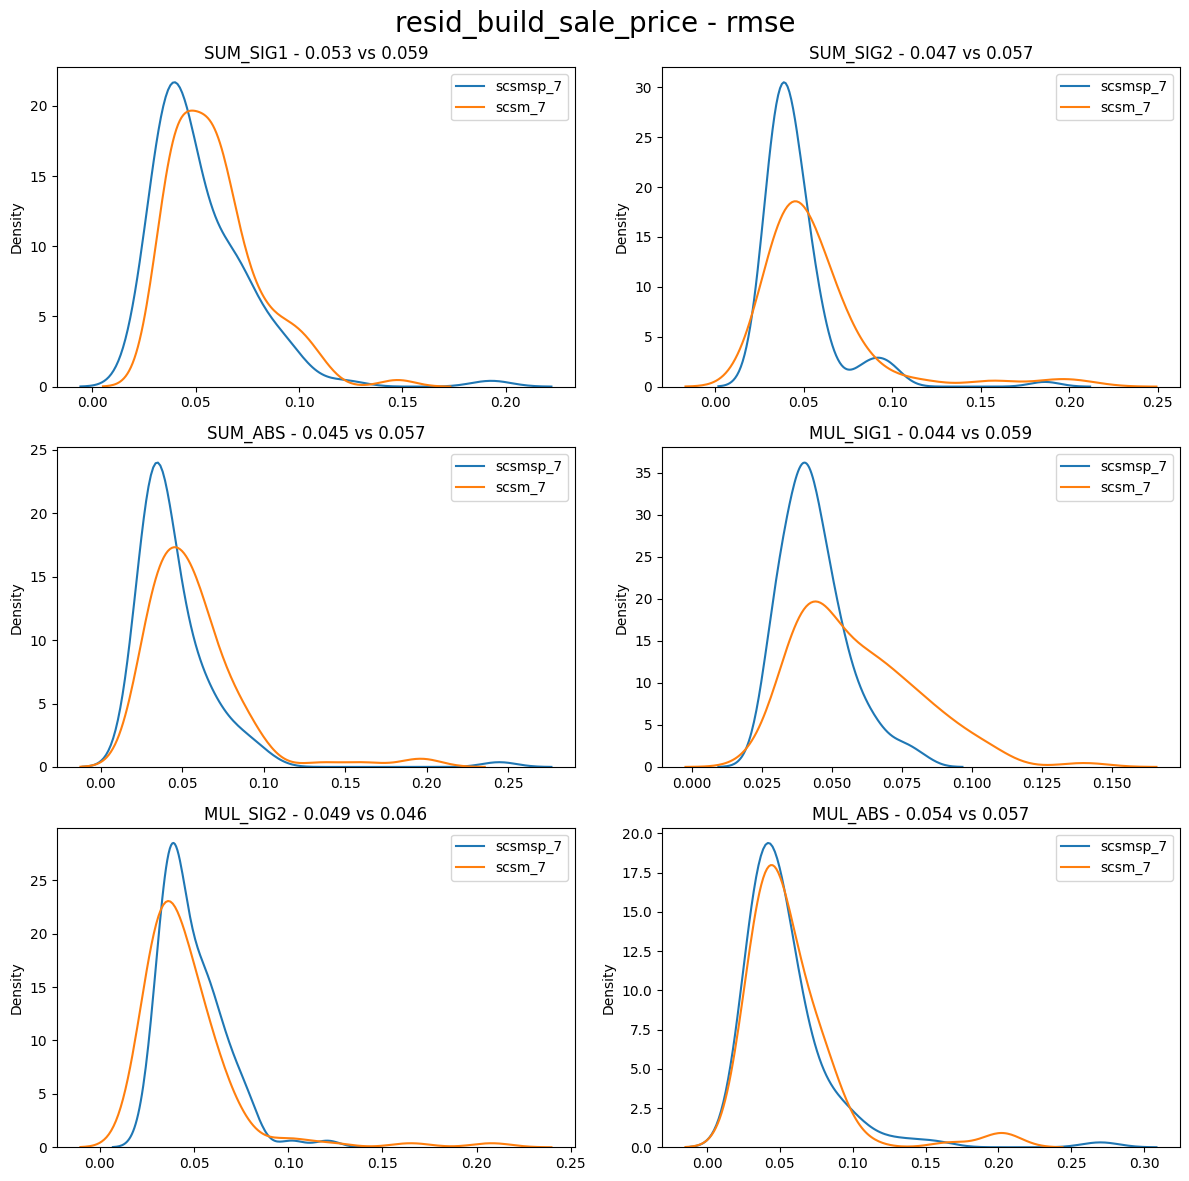

In [67]:
prefixes = ['scsmsp_7', 'scsm_7']
dataset = 'resid_build_sale_price'
dataset_id = dataset_dict[dataset]

with open(f'results/slim/{dataset_id}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)

with open(f'results/slim/{dataset_id}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)

algorithms = ['SUM_SIG1', 'SUM_SIG2', 'SUM_ABS', 'MUL_SIG1', 'MUL_SIG2', 'MUL_ABS']

# For each algorithm, plot the RMSE distribution for the two variants 
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

for i, algo in enumerate(algorithms):
    sns.kdeplot(results1['rmse'][algo], ax=axs[i], label=prefixes[0])
    sns.kdeplot(results2['rmse'][algo], ax=axs[i], label=prefixes[1])    
    axs[i].set_title(f'{algo} - {np.mean(results1['rmse'][algo]):.3f} vs {np.mean(results2['rmse'][algo]):.3f}')
    axs[i].legend()

fig.suptitle(f'{dataset} - {'rmse'}', fontsize=20)
plt.tight_layout()
plt.show()

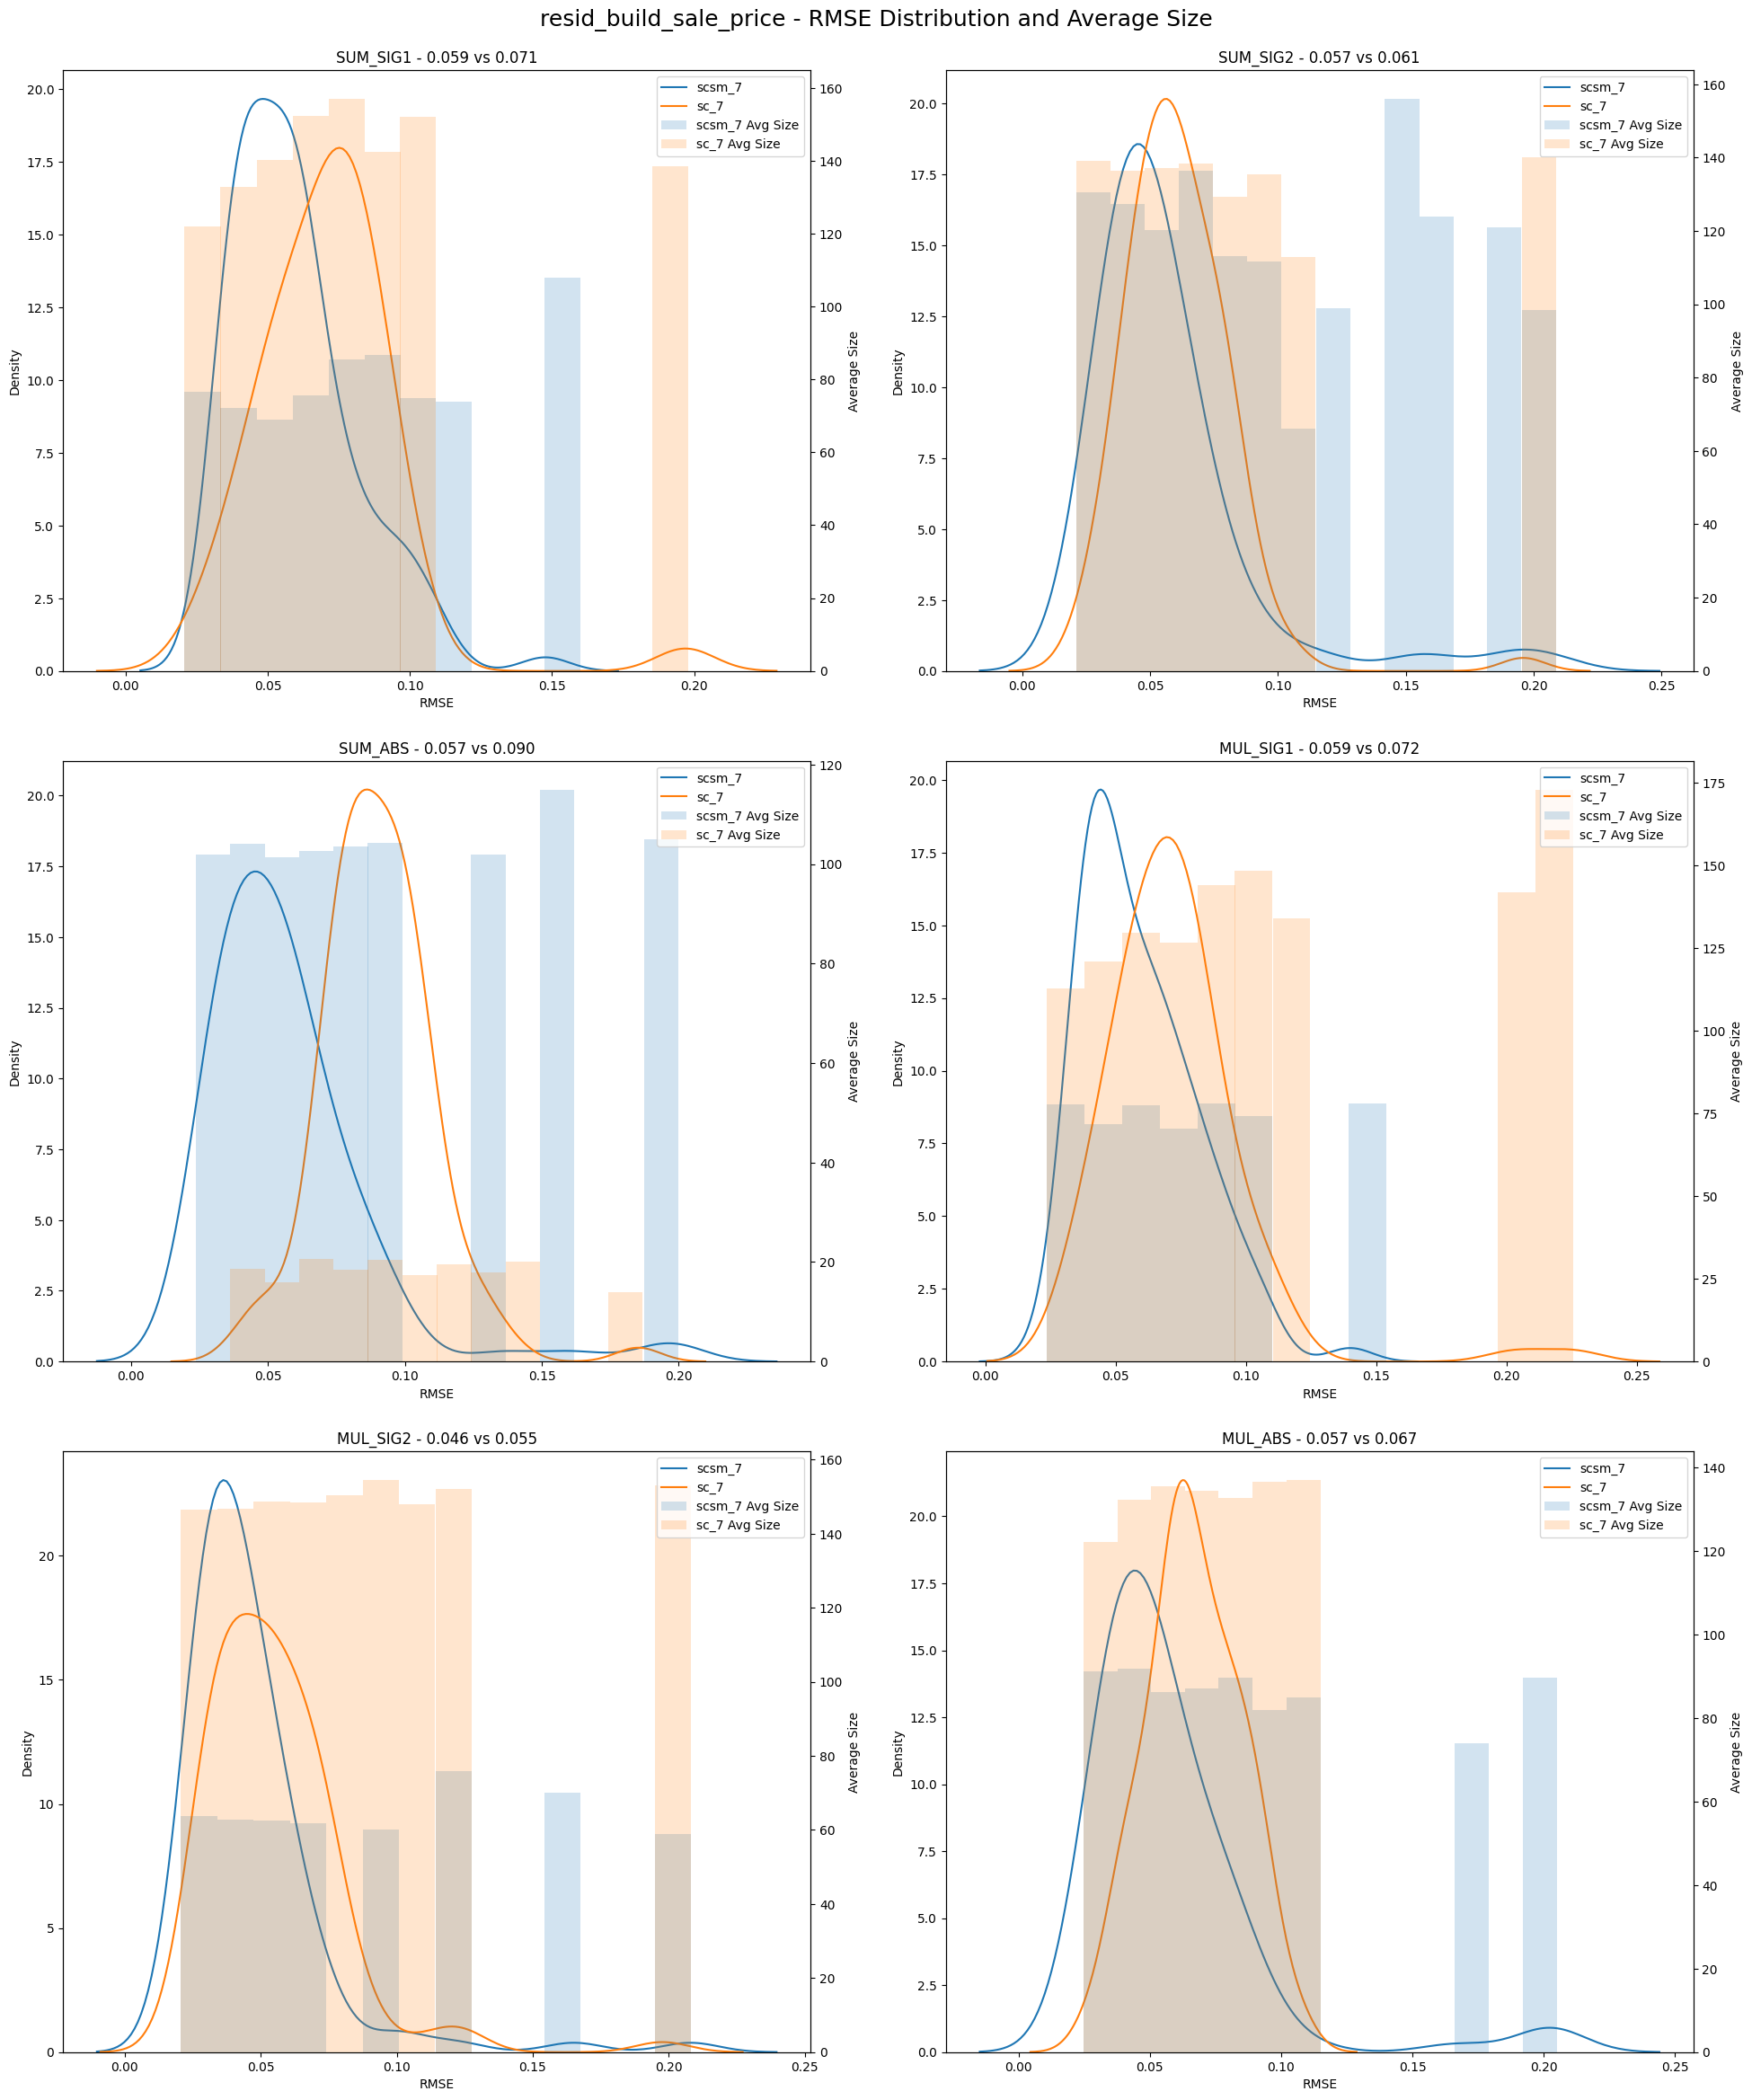

In [ ]:
n_bins = 14
prefixes = ['scsm_7', 'sc_7']
dataset = 'resid_build_sale_price'
best = True

dataset_id = dataset_dict[dataset]
with open(f'results/slim/{dataset_id}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)
with open(f'results/slim/{dataset_id}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)
algorithms = ['SUM_SIG1', 'SUM_SIG2', 'SUM_ABS', 'MUL_SIG1', 'MUL_SIG2', 'MUL_ABS']

def create_dataframe(results, prefix):
    data = []
    for algo in algorithms:
        for rmse, size in zip(results['rmse'][algo], results['size'][algo]):
            data.append({'algorithm': algo, 'rmse': rmse, 'size': size, 'prefix': prefix})
    return pd.DataFrame(data)

df1 = create_dataframe(results1, prefixes[0])
df2 = create_dataframe(results2, prefixes[1])
df = pd.concat([df1, df2])

def calculate_mean_size(data, bins):
    data = data.copy()
    data['rmse_bin'] = pd.cut(data['rmse'], bins=bins)
    return data.groupby('rmse_bin', observed=False)['size'].mean().reset_index()


fig, axs = plt.subplots(3, 2, figsize=(20, 24))
axs = axs.flatten()

for i, algo in enumerate(algorithms):
    algo_data = df[df['algorithm'] == algo]
    sns.kdeplot(data=algo_data[algo_data['prefix'] == prefixes[0]], x='rmse', ax=axs[i], label=prefixes[0])
    sns.kdeplot(data=algo_data[algo_data['prefix'] == prefixes[1]], x='rmse', ax=axs[i], label=prefixes[1])
    rmse_min = algo_data['rmse'].min()
    rmse_max = algo_data['rmse'].max()
    bins = np.linspace(rmse_min, rmse_max, n_bins+1)
    
    mean_size1 = calculate_mean_size(algo_data[algo_data['prefix'] == prefixes[0]], bins)
    mean_size2 = calculate_mean_size(algo_data[algo_data['prefix'] == prefixes[1]], bins)
    
    ax2 = axs[i].twinx()
    ax2.bar(mean_size1['rmse_bin'].apply(lambda x: x.mid), mean_size1['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[0]} Avg Size')
    ax2.bar(mean_size2['rmse_bin'].apply(lambda x: x.mid), mean_size2['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[1]} Avg Size')
    
    axs[i].set_title(f'{algo} - {np.mean(results1["rmse"][algo]):.3f} vs {np.mean(results2["rmse"][algo]):.3f}')
    axs[i].set_xlabel('RMSE')
    axs[i].set_ylabel('Density')
    ax2.set_ylabel('Average Size')
    
    lines1, labels1 = axs[i].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.suptitle(f'{dataset} - RMSE Distribution and Average Size', fontsize=18)
plt.tight_layout(pad=2.5)
plt.show()

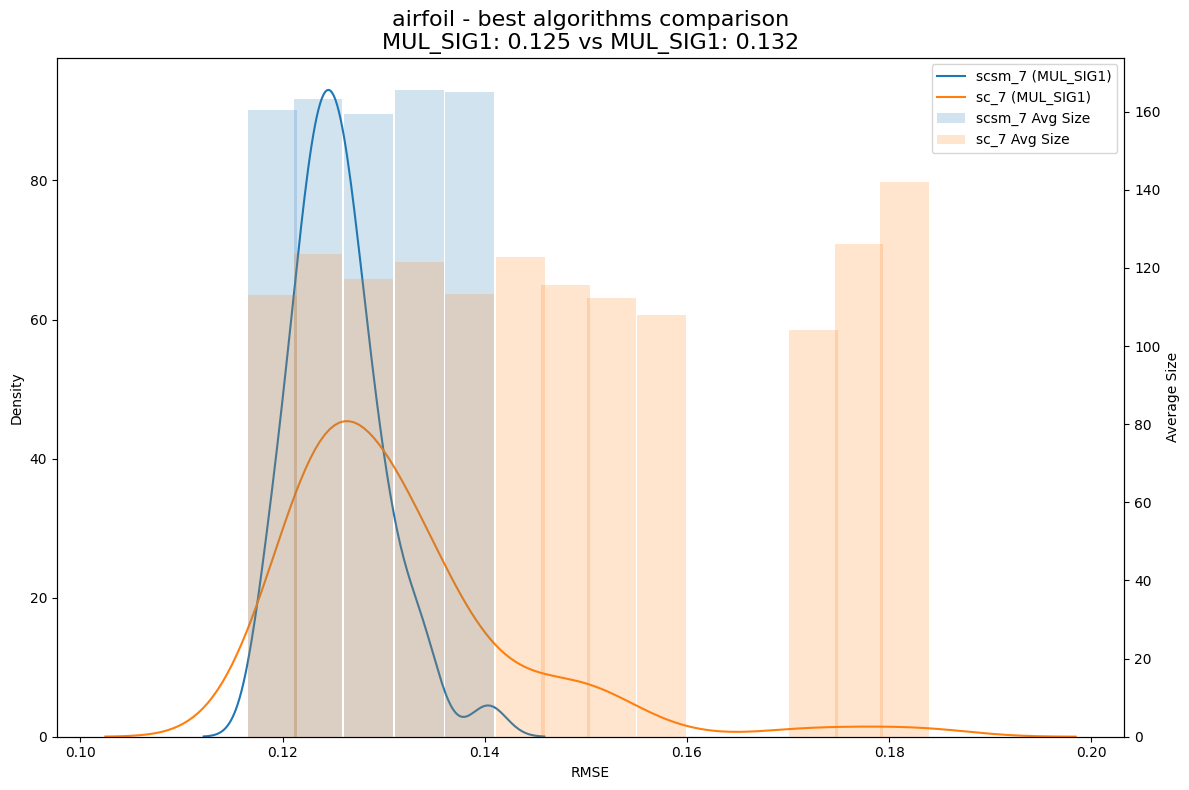

In [23]:
n_bins = 14
prefixes = ['scsm_7', 'sc_7']
# dataset = 'resid_build_sale_price'
dataset = 'airfoil' 

# Annahme: dataset_dict und die Ergebnisdateien sind verfügbar
dataset_id = dataset_dict[dataset]
with open(f'results/slim/{dataset_id}/{prefixes[0]}.pkl', 'rb') as f:
    results1 = pickle.load(f)
with open(f'results/slim/{dataset_id}/{prefixes[1]}.pkl', 'rb') as f:
    results2 = pickle.load(f)
algorithms = ['SUM_SIG1', 'SUM_SIG2', 'SUM_ABS', 'MUL_SIG1', 'MUL_SIG2', 'MUL_ABS']


def create_dataframe(results, prefix):
    data = []
    for algo in algorithms:
        for rmse, size in zip(results['rmse'][algo], results['size'][algo]):
            data.append({'algorithm': algo, 'rmse': rmse, 'size': size, 'prefix': prefix})
    return pd.DataFrame(data)

def calculate_mean_size(data, bins):
    data = data.copy()
    data['rmse_bin'] = pd.cut(data['rmse'], bins=bins)
    return data.groupby('rmse_bin', observed=False)['size'].mean().reset_index()
df1 = create_dataframe(results1, prefixes[0])
df2 = create_dataframe(results2, prefixes[1])
best_algo1 = df1.groupby('algorithm')['rmse'].mean().idxmin()
best_algo2 = df2.groupby('algorithm')['rmse'].mean().idxmin()
best_df1 = df1[df1['algorithm'] == best_algo1]
best_df2 = df2[df2['algorithm'] == best_algo2]
df = pd.concat([best_df1, best_df2])

fig, ax = plt.subplots(figsize=(12, 8))

sns.kdeplot(data=best_df1, x='rmse', ax=ax, label=f'{prefixes[0]} ({best_algo1})')
sns.kdeplot(data=best_df2, x='rmse', ax=ax, label=f'{prefixes[1]} ({best_algo2})')
rmse_min = df['rmse'].min()
rmse_max = df['rmse'].max()
bins = np.linspace(rmse_min, rmse_max, n_bins+1)
mean_size1 = calculate_mean_size(best_df1, bins)
mean_size2 = calculate_mean_size(best_df2, bins)

ax2 = ax.twinx()
ax2.bar(mean_size1['rmse_bin'].apply(lambda x: x.mid), mean_size1['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[0]} Avg Size')
ax2.bar(mean_size2['rmse_bin'].apply(lambda x: x.mid), mean_size2['size'], alpha=0.2, width=(rmse_max-rmse_min)/n_bins, label=f'{prefixes[1]} Avg Size')
ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
ax2.set_ylabel('Average Size')
plt.title(f'{dataset} - best algorithms comparison\n{best_algo1}: {best_df1["rmse"].mean():.3f} vs {best_algo2}: {best_df2["rmse"].mean():.3f}', fontsize=16)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()


In [22]:
dataset_dict

{'resid_build_sale_price': 'DA00',
 'istanbul': 'DA01',
 'airfoil': 'DA02',
 'bike_sharing': 'DA03',
 'boston': 'DA04',
 'breast_cancer': 'DA05',
 'concrete_slump': 'DA06',
 'concrete_strength': 'DA07',
 'diabetes': 'DA08',
 'efficiency_heating': 'DA09',
 'efficiency_cooling': 'DA10',
 'forest_fires': 'DA11',
 'ld50': 'DA12',
 'ppb': 'DA13',
 'bioav': 'DA14'}

In [24]:
with open('params/DA02/scsm_7.pkl', 'rb') as f:
    params = pickle.load(f)

params['MUL_SIG1']

{'p_inflate': np.float64(0.08),
 'max_depth': 17,
 'init_depth': 4,
 'tournament_size': 3,
 'prob_const': np.float64(0.18),
 'struct_mutation': 0.02,
 'decay_rate': np.float64(0.06),
 'p_struct': np.float64(0.24),
 'depth_distribution': np.str_('exp'),
 'pop_size': 120,
 'n_iter': 900,
 'p_xo': np.float64(0.0),
 'p_struct_xo': np.float64(0.0),
 'simplify_threshold': None}

In [15]:
means_df(prefixes=['scsm_7', 'sc_7'],
         best=True, rmse_compare=False, decimals=4, table=False)

Error in significance test: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements., ld50, SUM_SIG2, sc_7


,rmse_scsm_7,rmse_sc_7,ratio_rmse,rmse_significance,size_scsm_7,size_sc_7,ratio_size,size_significance
bike_sharing,0.0182,0.0384,0.4750,+++,91.46,98.86,0.9251,NSD
resid_build_sale_price,0.0463,0.0548,0.8441,+++,63.08,147.91,0.4265,+++
ppb,0.3174,0.3559,0.8920,NSD,140.94,255.49,0.5516,+++
concrete_strength,0.1033,0.1118,0.9247,+++,218.58,139.42,1.5678,---
efficiency_heating,0.0586,0.0623,0.9408,++,177.87,150.25,1.1838,---
breast_cancer,0.2579,0.2714,0.9501,+++,109.61,134.29,0.8162,+++
airfoil,0.1255,0.1316,0.9535,+++,162.09,119.65,1.3547,---
efficiency_cooling,0.0784,0.0818,0.9588,+,137.84,143.08,0.9634,+
boston,0.1149,0.1187,0.9684,NSD,104.39,73.72,1.4160,---
diabetes,0.1934,0.1950,0.9919,+,139.99,100.02,1.3996,---


In [9]:
with open('params/DA00/scsm_5.pkl', 'rb') as f:
    params = pickle.load(f)['MUL_ABS']

params.pop('simplify_threshold')
X,y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=60)

rm, mp, ma, rm_c, mp_c, ma_c, time_stats, size, reps = test_slim(
            X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
            args_dict=params, dataset_name=name, verbose=1,
            n_samples=50, n_elites=1, simplify_threshold=0.02,
            # callbacks=[early_stopping],
        )

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:30<24:34, 30.10s/it]

Iteration 1/50 - RMSE: 0.1027 - SIZE: 82.0 - MAE: 0.0410 - Time: 30.09s


  4%|▍         | 2/50 [01:00<24:11, 30.24s/it]

Iteration 2/50 - RMSE: 0.0535 - SIZE: 85.0 - MAE: 0.0315 - Time: 30.33s


  6%|▌         | 3/50 [01:31<23:49, 30.41s/it]

Iteration 3/50 - RMSE: 0.0496 - SIZE: 80.0 - MAE: 0.0280 - Time: 30.61s


  8%|▊         | 4/50 [02:01<23:18, 30.41s/it]

Iteration 4/50 - RMSE: 0.0364 - SIZE: 81.0 - MAE: 0.0254 - Time: 30.40s


 10%|█         | 5/50 [02:34<23:26, 31.25s/it]

Iteration 5/50 - RMSE: 0.0569 - SIZE: 94.0 - MAE: 0.0304 - Time: 32.72s


 12%|█▏        | 6/50 [03:04<22:47, 31.08s/it]

Iteration 6/50 - RMSE: 0.0354 - SIZE: 91.0 - MAE: 0.0277 - Time: 30.75s


 14%|█▍        | 7/50 [03:36<22:17, 31.11s/it]

Iteration 7/50 - RMSE: 0.0432 - SIZE: 69.0 - MAE: 0.0294 - Time: 31.17s


 16%|█▌        | 8/50 [04:05<21:30, 30.72s/it]

Iteration 8/50 - RMSE: 0.0426 - SIZE: 71.0 - MAE: 0.0282 - Time: 29.87s


 18%|█▊        | 9/50 [04:36<20:51, 30.54s/it]

Iteration 9/50 - RMSE: 0.0359 - SIZE: 84.0 - MAE: 0.0246 - Time: 30.12s


 20%|██        | 10/50 [05:06<20:19, 30.50s/it]

Iteration 10/50 - RMSE: 0.0614 - SIZE: 93.0 - MAE: 0.0412 - Time: 30.41s


 22%|██▏       | 11/50 [05:37<19:50, 30.53s/it]

Iteration 11/50 - RMSE: 0.0343 - SIZE: 57.0 - MAE: 0.0235 - Time: 30.57s


 24%|██▍       | 12/50 [06:06<19:11, 30.32s/it]

Iteration 12/50 - RMSE: 0.0389 - SIZE: 71.0 - MAE: 0.0288 - Time: 29.83s


 26%|██▌       | 13/50 [06:36<18:29, 29.98s/it]

Iteration 13/50 - RMSE: 0.0477 - SIZE: 86.0 - MAE: 0.0394 - Time: 29.21s


 28%|██▊       | 14/50 [07:07<18:12, 30.35s/it]

Iteration 14/50 - RMSE: 0.0470 - SIZE: 95.0 - MAE: 0.0270 - Time: 31.20s


 30%|███       | 15/50 [07:37<17:40, 30.29s/it]

Iteration 15/50 - RMSE: 0.0851 - SIZE: 72.0 - MAE: 0.0423 - Time: 30.15s


 32%|███▏      | 16/50 [08:07<17:10, 30.32s/it]

Iteration 16/50 - RMSE: 0.0665 - SIZE: 72.0 - MAE: 0.0361 - Time: 30.37s


 34%|███▍      | 17/50 [08:37<16:33, 30.10s/it]

Iteration 17/50 - RMSE: 0.0286 - SIZE: 60.0 - MAE: 0.0209 - Time: 29.60s


 36%|███▌      | 18/50 [09:06<15:57, 29.91s/it]

Iteration 18/50 - RMSE: 0.0899 - SIZE: 68.0 - MAE: 0.0433 - Time: 29.46s


 38%|███▊      | 19/50 [09:35<15:17, 29.59s/it]

Iteration 19/50 - RMSE: 0.0359 - SIZE: 74.0 - MAE: 0.0264 - Time: 28.84s


 40%|████      | 20/50 [10:05<14:45, 29.52s/it]

Iteration 20/50 - RMSE: 0.0592 - SIZE: 70.0 - MAE: 0.0388 - Time: 29.34s


 42%|████▏     | 21/50 [10:34<14:14, 29.47s/it]

Iteration 21/50 - RMSE: 0.0404 - SIZE: 82.0 - MAE: 0.0282 - Time: 29.35s


 44%|████▍     | 22/50 [11:05<13:53, 29.77s/it]

Iteration 22/50 - RMSE: 0.0817 - SIZE: 71.0 - MAE: 0.0489 - Time: 30.47s


 46%|████▌     | 23/50 [11:34<13:24, 29.79s/it]

Iteration 23/50 - RMSE: 0.0626 - SIZE: 87.0 - MAE: 0.0349 - Time: 29.84s


 48%|████▊     | 24/50 [12:06<13:09, 30.37s/it]

Iteration 24/50 - RMSE: 0.0486 - SIZE: 82.0 - MAE: 0.0347 - Time: 31.72s


 50%|█████     | 25/50 [12:36<12:35, 30.23s/it]

Iteration 25/50 - RMSE: 0.0519 - SIZE: 76.0 - MAE: 0.0272 - Time: 29.90s


 52%|█████▏    | 26/50 [13:07<12:08, 30.37s/it]

Iteration 26/50 - RMSE: 0.0495 - SIZE: 84.0 - MAE: 0.0345 - Time: 30.67s


 54%|█████▍    | 27/50 [13:36<11:33, 30.15s/it]

Iteration 27/50 - RMSE: 0.0303 - SIZE: 80.0 - MAE: 0.0220 - Time: 29.63s


 56%|█████▌    | 28/50 [14:06<10:59, 29.97s/it]

Iteration 28/50 - RMSE: 0.0331 - SIZE: 61.0 - MAE: 0.0243 - Time: 29.56s


 58%|█████▊    | 29/50 [14:36<10:28, 29.93s/it]

Iteration 29/50 - RMSE: 0.0284 - SIZE: 72.0 - MAE: 0.0215 - Time: 29.83s


 60%|██████    | 30/50 [15:06<10:02, 30.13s/it]

Iteration 30/50 - RMSE: 0.0762 - SIZE: 82.0 - MAE: 0.0410 - Time: 30.58s


 62%|██████▏   | 31/50 [15:36<09:28, 29.92s/it]

Iteration 31/50 - RMSE: 0.0466 - SIZE: 20.0 - MAE: 0.0343 - Time: 29.43s


 64%|██████▍   | 32/50 [16:06<09:01, 30.06s/it]

Iteration 32/50 - RMSE: 0.0858 - SIZE: 69.0 - MAE: 0.0494 - Time: 30.37s


 66%|██████▌   | 33/50 [16:35<08:27, 29.83s/it]

Iteration 33/50 - RMSE: 0.0290 - SIZE: 59.0 - MAE: 0.0211 - Time: 29.31s


 68%|██████▊   | 34/50 [17:06<07:59, 29.99s/it]

Iteration 34/50 - RMSE: 0.0536 - SIZE: 56.0 - MAE: 0.0287 - Time: 30.36s


 70%|███████   | 35/50 [17:35<07:28, 29.90s/it]

Iteration 35/50 - RMSE: 0.0447 - SIZE: 74.0 - MAE: 0.0330 - Time: 29.67s


 72%|███████▏  | 36/50 [18:07<07:04, 30.31s/it]

Iteration 36/50 - RMSE: 0.0448 - SIZE: 82.0 - MAE: 0.0300 - Time: 31.27s


 74%|███████▍  | 37/50 [18:36<06:29, 29.96s/it]

Iteration 37/50 - RMSE: 0.0481 - SIZE: 65.0 - MAE: 0.0308 - Time: 29.14s


 76%|███████▌  | 38/50 [19:05<05:57, 29.83s/it]

Iteration 38/50 - RMSE: 0.0678 - SIZE: 70.0 - MAE: 0.0412 - Time: 29.50s


 78%|███████▊  | 39/50 [19:35<05:27, 29.77s/it]

Iteration 39/50 - RMSE: 0.0362 - SIZE: 80.0 - MAE: 0.0252 - Time: 29.62s


 80%|████████  | 40/50 [20:05<04:58, 29.87s/it]

Iteration 40/50 - RMSE: 0.0605 - SIZE: 71.0 - MAE: 0.0401 - Time: 30.12s


 82%|████████▏ | 41/50 [20:35<04:29, 29.93s/it]

Iteration 41/50 - RMSE: 0.0696 - SIZE: 70.0 - MAE: 0.0424 - Time: 30.06s


 84%|████████▍ | 42/50 [21:06<04:02, 30.33s/it]

Iteration 42/50 - RMSE: 0.0535 - SIZE: 72.0 - MAE: 0.0419 - Time: 31.26s


 86%|████████▌ | 43/50 [21:38<03:34, 30.60s/it]

Iteration 43/50 - RMSE: 0.0439 - SIZE: 69.0 - MAE: 0.0296 - Time: 31.22s


 88%|████████▊ | 44/50 [22:09<03:04, 30.73s/it]

Iteration 44/50 - RMSE: 0.0433 - SIZE: 72.0 - MAE: 0.0325 - Time: 31.02s


 90%|█████████ | 45/50 [22:39<02:32, 30.58s/it]

Iteration 45/50 - RMSE: 0.0376 - SIZE: 93.0 - MAE: 0.0230 - Time: 30.22s


 92%|█████████▏| 46/50 [23:10<02:02, 30.57s/it]

Iteration 46/50 - RMSE: 0.0297 - SIZE: 89.0 - MAE: 0.0202 - Time: 30.55s


 94%|█████████▍| 47/50 [23:39<01:31, 30.38s/it]

Iteration 47/50 - RMSE: 0.0513 - SIZE: 69.0 - MAE: 0.0316 - Time: 29.91s


 96%|█████████▌| 48/50 [24:09<01:00, 30.19s/it]

Iteration 48/50 - RMSE: 0.0360 - SIZE: 65.0 - MAE: 0.0265 - Time: 29.74s


 98%|█████████▊| 49/50 [24:38<00:29, 29.89s/it]

Iteration 49/50 - RMSE: 0.0322 - SIZE: 44.0 - MAE: 0.0235 - Time: 29.19s


100%|██████████| 50/50 [25:08<00:00, 30.18s/it]

Iteration 50/50 - RMSE: 0.0322 - SIZE: 57.0 - MAE: 0.0241 - Time: 29.87s


In [268]:
means_df(prefixes=['scsmsp_5', 'scsm_5'],
         best=True, rmse_compare=False, decimals=4, table=True)

╒════════════════════════╤═════════════════╤═════════════════╤══════════════╤═════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════════════════╕
│                        │ rmse_scsmsp_5   │ rmse_scsm_5     │   ratio_rmse │ rmse_significance   │ size_scsmsp_5    │ size_scsm_5      │   ratio_size │ size_significance   │
╞════════════════════════╪═════════════════╪═════════════════╪══════════════╪═════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════════════════╡
│ resid_build_sale_price │ 0.0464 ± 0.0142 │ 0.0495 ± 0.0149 │       0.9374 │ NSD                 │ 94.58 ± 16.4512  │ 74.26 ± 12.8138  │       1.2736 │ ---                 │
├────────────────────────┼─────────────────┼─────────────────┼──────────────┼─────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────────────────┤
│ concrete_slump         │ 0.2498 ± 0.0206 │ 0.2581 ± 0.0418 │       0.9679 │ NSD                 │ 86.42 ± 28.6043  │ 72.86 

In [190]:
means_df(prefixes=['scsm_3', 'sc_3'],
         best=False, rmse_compare=False, decimals=4, table=False)

rmse_scsm_4  rmse_sc_4  size_scsm_4  \
Dataset                Algorithm                                        
bike_sharing           MUL_SIG2        0.0290     0.0857       156.86   
                       MUL_SIG1        0.0229     0.0566        97.44   
                       SUM_SIG1        0.0245     0.0519        74.26   
resid_build_sale_price MUL_SIG1        0.0470     0.0856       109.94   
efficiency_heating     MUL_SIG2        0.0781     0.1251       162.50   
...                                       ...        ...          ...   
breast_cancer          SUM_SIG1        0.3082     0.2777       157.56   
ld50                   MUL_SIG1        0.2475     0.2225        50.74   
bioav                  MUL_SIG1        0.3584     0.3215        49.90   
ld50                   MUL_ABS         0.2703     0.2229        61.88   
resid_build_sale_price MUL_ABS         0.1084     0.0743       141.90   

                                  size_sc_4  ratio_rmse  ratio_size  \
Dataset                Algorithm                                      
bike_sharing           MUL_SIG2       47.24      0.3383      3.3205   
                       MUL_SIG1      135.82      0.4054      0.7174   
                       SUM_SIG1       98.78      0.4710      0.7518   
resid_build_sale_price MUL_SIG1       31.30      0.5497      3.5125   
efficiency_heating     MUL_SIG2       17.04      0.6242      9.5364   
...                                     ...         ...         ...   
breast_cancer          SUM_SIG1      322.76      1.1098      0.4882   
ld50                   MUL_SIG1       46.90      1.1124      1.0819   
bioav                  MUL_SIG1       30.26      1.1149      1.6490   
ld50                   MUL_ABS        17.24      1.2126      3.5893   
resid_build_sale_price MUL_ABS       110.94      1.4579      1.2791   

                                 rmse_significance size_significance  
Dataset                Algorithm                                      
bike_sharing           MUL_SIG2                +++               ---  
                       MUL_SIG1                +++                ++  
                       SUM_SIG1                +++               +++  
resid_build_sale_price MUL_SIG1                +++               ---  
efficiency_heating     MUL_SIG2                +++               ---  
...                                            ...               ...  
breast_cancer          SUM_SIG1                ---               +++  
ld50                   MUL_SIG1                NSD                --  
bioav                  MUL_SIG1                NSD               ---  
ld50                   MUL_ABS                 NSD               ---  
resid_build_sale_price MUL_ABS                 ---                --  

[90 rows x 8 columns]

In [197]:
means_df(prefixes=['scsmsp_4', 'scsm_4'],
         best=False, rmse_compare=False, decimals=4, table=False).value_counts('size_significance')

size_significance
+++    61
---    11
NSD    10
+       3
-       3
++      2
Name: count, dtype: int64

In [193]:
means_df(prefixes=['scsm_4', 'sc_4'],
         best=True, rmse_compare=False, decimals=4, table=False)

,rmse_scsm_4,rmse_sc_4,ratio_rmse,rmse_significance,size_scsm_4,size_sc_4,ratio_size,size_significance
bike_sharing,0.0229,0.0428,0.5359,+++,97.44,128.62,0.7576,+++
resid_build_sale_price,0.0451,0.0578,0.7805,++,208.32,113.90,1.8290,---
boston,0.1344,0.1498,0.8971,+++,191.88,88.26,2.1740,---
efficiency_cooling,0.0828,0.0920,0.9006,+++,177.12,230.64,0.7680,+++
efficiency_heating,0.0737,0.0812,0.9074,+,152.86,84.00,1.8198,---
airfoil,0.1210,0.1284,0.9424,+++,181.12,88.64,2.0433,---
istanbul,0.0761,0.0782,0.9727,+,75.92,43.96,1.7270,---
bioav,0.3168,0.3215,0.9856,NSD,18.16,30.26,0.6001,+++
forest_fires,0.2332,0.2364,0.9865,NSD,88.74,16.88,5.2571,---
diabetes,0.1799,0.1820,0.9880,NSD,103.38,159.74,0.6472,+++


In [240]:
df = means_df(prefixes=['scsm', 'sc'],
         best=True, rmse_compare=False, decimals=4, table=False)

df

,rmse_scsm,rmse_sc,ratio_rmse,rmse_significance,size_scsm,size_sc,ratio_size,size_significance
bike_sharing,0.0217,0.0291,0.7434,+,92.3333,183.9333,0.5020,+++
resid_build_sale_price,0.0371,0.0449,0.8268,++,91.6667,247.6667,0.3701,+++
concrete_strength,0.0924,0.1086,0.8507,+++,206.8333,167.5000,1.2348,---
boston,0.0853,0.0960,0.8888,++,92.1000,183.0667,0.5031,+++
airfoil,0.1184,0.1304,0.9077,++,98.0333,168.2000,0.5828,+++
concrete_slump,0.2689,0.2896,0.9286,+,90.7333,86.1333,1.0534,NSD
bioav,0.2485,0.2635,0.9431,+,98.3667,97.2333,1.0117,NSD
ppb,0.2622,0.2692,0.9737,NSD,94.9333,89.0667,1.0659,NSD
breast_cancer,0.2393,0.2420,0.9889,NSD,96.3000,163.0333,0.5907,+++
istanbul,0.0626,0.0633,0.9895,NSD,91.0333,148.9667,0.6111,+++


In [49]:
df = means_df(prefixes=['scsm', 'sc'],
         best=False, rmse_compare=False, decimals=4, table=False)

# For each dataset, apply a scaler to the rmse_scsm and rmse_sc columns
maxs = df.groupby('Dataset').max()[['rmse_scsm', 'rmse_sc']].max(axis=1)
mins = df.groupby('Dataset').min()[['rmse_scsm', 'rmse_sc']].min(axis=1)
df['rmse_scsm_scaled'] = (df['rmse_scsm'] - mins) / (maxs - mins)
df['rmse_sc_scaled'] = (df['rmse_sc'] - mins) / (maxs - mins)

# Scale the sizes
maxs = df.groupby('Dataset').max()[['size_scsm', 'size_sc']].max(axis=1)
mins = df.groupby('Dataset').min()[['size_scsm', 'size_sc']].min(axis=1)
df['size_scsm_scaled'] = (df['size_scsm'] - mins) / (maxs - mins)
df['size_sc_scaled'] = (df['size_sc'] - mins) / (maxs - mins)

# Create a score column
df['score_scsm'] = df['rmse_scsm_scaled'] + 0.5 * df['size_scsm_scaled']
df['score_sc'] = df['rmse_sc_scaled'] + 0.5 * df['size_sc_scaled']

# Drop the scaled columns
df.drop(columns=['rmse_scsm_scaled', 'rmse_sc_scaled', 'size_scsm_scaled', 'size_sc_scaled'], inplace=True)

In [56]:
# Get, for each dataset the best algorithm
best_indices = df.groupby('Dataset')[['score_scsm', 'score_sc']].idxmin().values.flatten()
best_df = df.loc[best_indices]

# For which datasets is scsm better than sc? Youll need to pivot the table
df

rmse_scsm  rmse_sc  size_scsm   size_sc  \
Dataset            Algorithm                                            
bike_sharing       SUM_SIG2      0.0269   0.0580    85.7000  150.0000   
                   MUL_ABS       0.0341   0.0627    86.8333   77.1000   
                   MUL_SIG2      0.0225   0.0405    87.0333   80.3000   
                   MUL_SIG1      0.0299   0.0528    90.0667  150.0333   
ppb                MUL_SIG1      0.2841   0.4905    91.8000  181.4333   
...                                 ...      ...        ...       ...   
istanbul           MUL_SIG1      0.0738   0.0633    91.7000  148.9667   
efficiency_cooling SUM_ABS       0.0847   0.0705    95.1000  278.6667   
ppb                SUM_ABS       0.3847   0.2692    87.3667   89.0667   
                   SUM_SIG1      0.4478   0.2730    89.7000  172.9000   
                   MUL_ABS       0.4868   0.2816    99.0000   87.2667   

                              ratio_rmse  ratio_size  score_scsm  score_sc  \
Dataset            Algorithm                                                 
bike_sharing       SUM_SIG2       0.4628      0.5713    0.167079  1.226552   
                   MUL_ABS        0.5429      1.1262    0.347993  1.000000   
                   MUL_SIG2       0.5555      1.0839    0.066002  0.473513   
                   MUL_SIG1       0.5663      0.6003    0.260687  1.099878   
ppb                MUL_SIG1       0.5793      0.5060    0.119997  1.500000   
...                                  ...         ...         ...       ...   
istanbul           MUL_SIG1       1.1668      0.6156    1.052737  0.497525   
efficiency_cooling SUM_ABS        1.2018      0.3413    0.531005  0.500000   
ppb                SUM_ABS        1.4288      0.9809    0.537106  0.040219   
                   SUM_SIG1       1.6402      0.5188    0.825886  0.501997   
                   MUL_ABS        1.7288      1.1345    1.046094  0.084976   

                              scsm_better  
Dataset            Algorithm               
bike_sharing       SUM_SIG2          True  
                   MUL_ABS           True  
                   MUL_SIG2          True  
                   MUL_SIG1          True  
ppb                MUL_SIG1          True  
...                                   ...  
istanbul           MUL_SIG1         False  
efficiency_cooling SUM_ABS          False  
ppb                SUM_ABS          False  
                   SUM_SIG1         False  
                   MUL_ABS          False  

[90 rows x 9 columns]

### PARAMS